In [2]:
import scipy
from itertools import combinations_with_replacement

from scipy.stats import wasserstein_distance
from setup import neurotransmitters, model_size, device, feat_dim, resize_size, dataset_path, curated_idx, few_shot_transforms, model
from setup import tqdm, torch, np, os, h5py, sns, plt, tqdm
from perso_utils import get_fnames, load_image
from DINOSim import DinoSim_pipeline
from napari_dinosim.utils import get_img_processing_f
# Create an instance of the pipeline (not just assigning the class)

few_shot = DinoSim_pipeline(model,
                            model.patch_size,
                            device,
                            get_img_processing_f(resize_size),
                            feat_dim, 
                            dino_image_size=resize_size
                            )

Device: cpu


Using cache found in /home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded


In [4]:
saved_ref_embeddings = True # (but has to be done again)

data_aug = False

if saved_ref_embeddings == False:

    files, labels = zip(*get_fnames()) 

    if data_aug:    
        nb_transformations = len(few_shot_transforms)
        
        # Preload images and metadata once
        good_images = []
        transformed_coordinates = []

        for idx in curated_idx:
            img, coord_x, coord_y = load_image(files[idx])
            good_images.append(img.transpose(1,2,0))
            transformed_coordinates.append([(0, coord_x, coord_y)] * nb_transformations)

        transformed_images = []
        for image in good_images:
            transformed = [t(image).permute(1,2,0) for t in few_shot_transforms]
            transformed_images.extend(transformed)

        for j, img in enumerate(transformed_images):
            if img.shape != torch.Size([130, 130, 1]):
                h, w = img.shape[:2]
                h_diff = (130 - h) // 2
                w_diff = (130 - w) // 2
                padded_img = torch.zeros(130, 130, 1)
                padded_img[h_diff:h+h_diff, w_diff:w+w_diff, :] = img
                transformed_images[j] = padded_img
                
        batch_size = int(len(curated_idx)/len(neurotransmitters)*nb_transformations) # nb of images in per class
        good_datasets = [transformed_images[i:i+batch_size] for i in range(0,len(transformed_images),batch_size)]
        good_datasets = np.array(good_datasets)
        
        transformed_coordinates = np.vstack(transformed_coordinates)
        good_coordinates = [transformed_coordinates[i:i+batch_size] for i in range(0,len(transformed_coordinates),batch_size)]

    else:

        imgs_coords = [load_image(files[idx]) for idx in curated_idx]
        imgs, xs, ys = zip(*imgs_coords)

        batch_size = int(len(curated_idx)/len(neurotransmitters))
        imgs = [imgs[i:i+batch_size] for i in range(0,len(imgs),batch_size)]
        good_datasets = np.array(imgs).transpose(0,1,3,4,2)
        
        good_coordinates = [(0, x, y) for x, y in zip(xs, ys)]
        good_coordinates = [good_coordinates[i:i+batch_size] for i in range(0,len(good_coordinates),batch_size)]
        good_coordinates = np.array(good_coordinates)


    unfiltered_ref_latents_list, filtered_latent_list, filtered_label_list = [], [], []
    for dataset, batch_label, coordinates in tqdm(zip(good_datasets, neurotransmitters, good_coordinates), desc='Iterating through neurotransmitters'):
        
        # Pre-compute embeddings
        few_shot.pre_compute_embeddings(
            dataset,  # Pass numpy array of images
            overlap= (0, 0), #(0.5, 0.5),
            padding=(0, 0),
            crop_shape=(518, 518, 1),
            verbose=True,
            batch_size=10
        )
        
        unfiltered_ref_latents = few_shot.get_embs()
        
        unfiltered_ref_latents_list.append(unfiltered_ref_latents)

        # Clean up to free memory
        few_shot.delete_precomputed_embeddings()
        few_shot.delete_references()

    unfiltered_ref_latents = np.array(unfiltered_ref_latents_list)
    
    torch.save(unfiltered_ref_latents, os.path.join('/home/tomwelch/Cambridge/Embeddings', f'Unfiltered_ref_latents_model_size={model_size}_img_size={resize_size}_Aug={data_aug}.pt'))

else:

    unfiltered_ref_latents = torch.load('/home/tomwelch/Cambridge/Embeddings/Unfiltered_ref_latents_model_size=giant_img_size=518_Aug=False.pt', weights_only=False) #TODO: For Linux

In [5]:
if data_aug:
    pass
else:
    nb_transformations = 1
    
nb_images = (len(curated_idx)*nb_transformations)
nb_patches_per_image = int(unfiltered_ref_latents.shape[1]*(len(neurotransmitters)/len(curated_idx)))
nb_images_per_class = int((len(curated_idx)*nb_transformations)/len(neurotransmitters))

In [6]:
ls = []
for neuro in unfiltered_ref_latents:
    ls.append([neuro[i:i+nb_patches_per_image] for i in range(0, unfiltered_ref_latents.shape[1], nb_patches_per_image)])
embds = np.array(ls)
embds.shape

(6, 10, 1369, 1536)

In [7]:

#embs = list 

#i,j wassersetin distance between each embedding sets 60x60 matrix

# Wassersetin might be symetric but f-Divergents are not

ref_embeddings = unfiltered_ref_latents.reshape(60, 1369, 1536)

A_dim = ref_embeddings.shape[0]

A = np.zeros((A_dim, A_dim))

from joblib import Parallel, delayed
from scipy.stats import wasserstein_distance
import numpy as np

flattened = [e.ravel() for e in ref_embeddings]

def compute_pair(i, j):
    dist = wasserstein_distance(flattened[i], flattened[j])
    return (i, j, dist)

pairs = [(i, j) for i in range(A_dim) for j in range(i, A_dim)]

results = Parallel(n_jobs=-1)(delayed(compute_pair)(i, j) for i, j in tqdm(pairs))

for i, j, dist in results:
    A[i, j] = A[j, i] = dist



100%|██████████| 1830/1830 [21:38<00:00,  1.41it/s]


<Axes: >

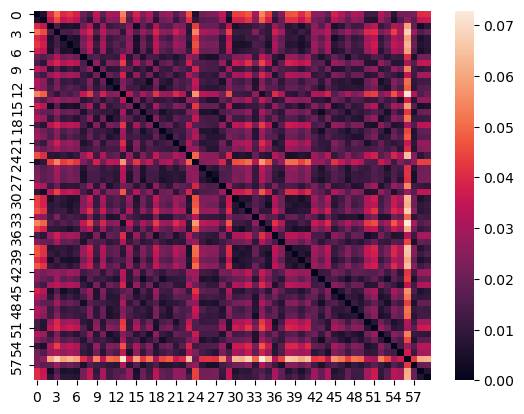

In [8]:
sns.heatmap(A)

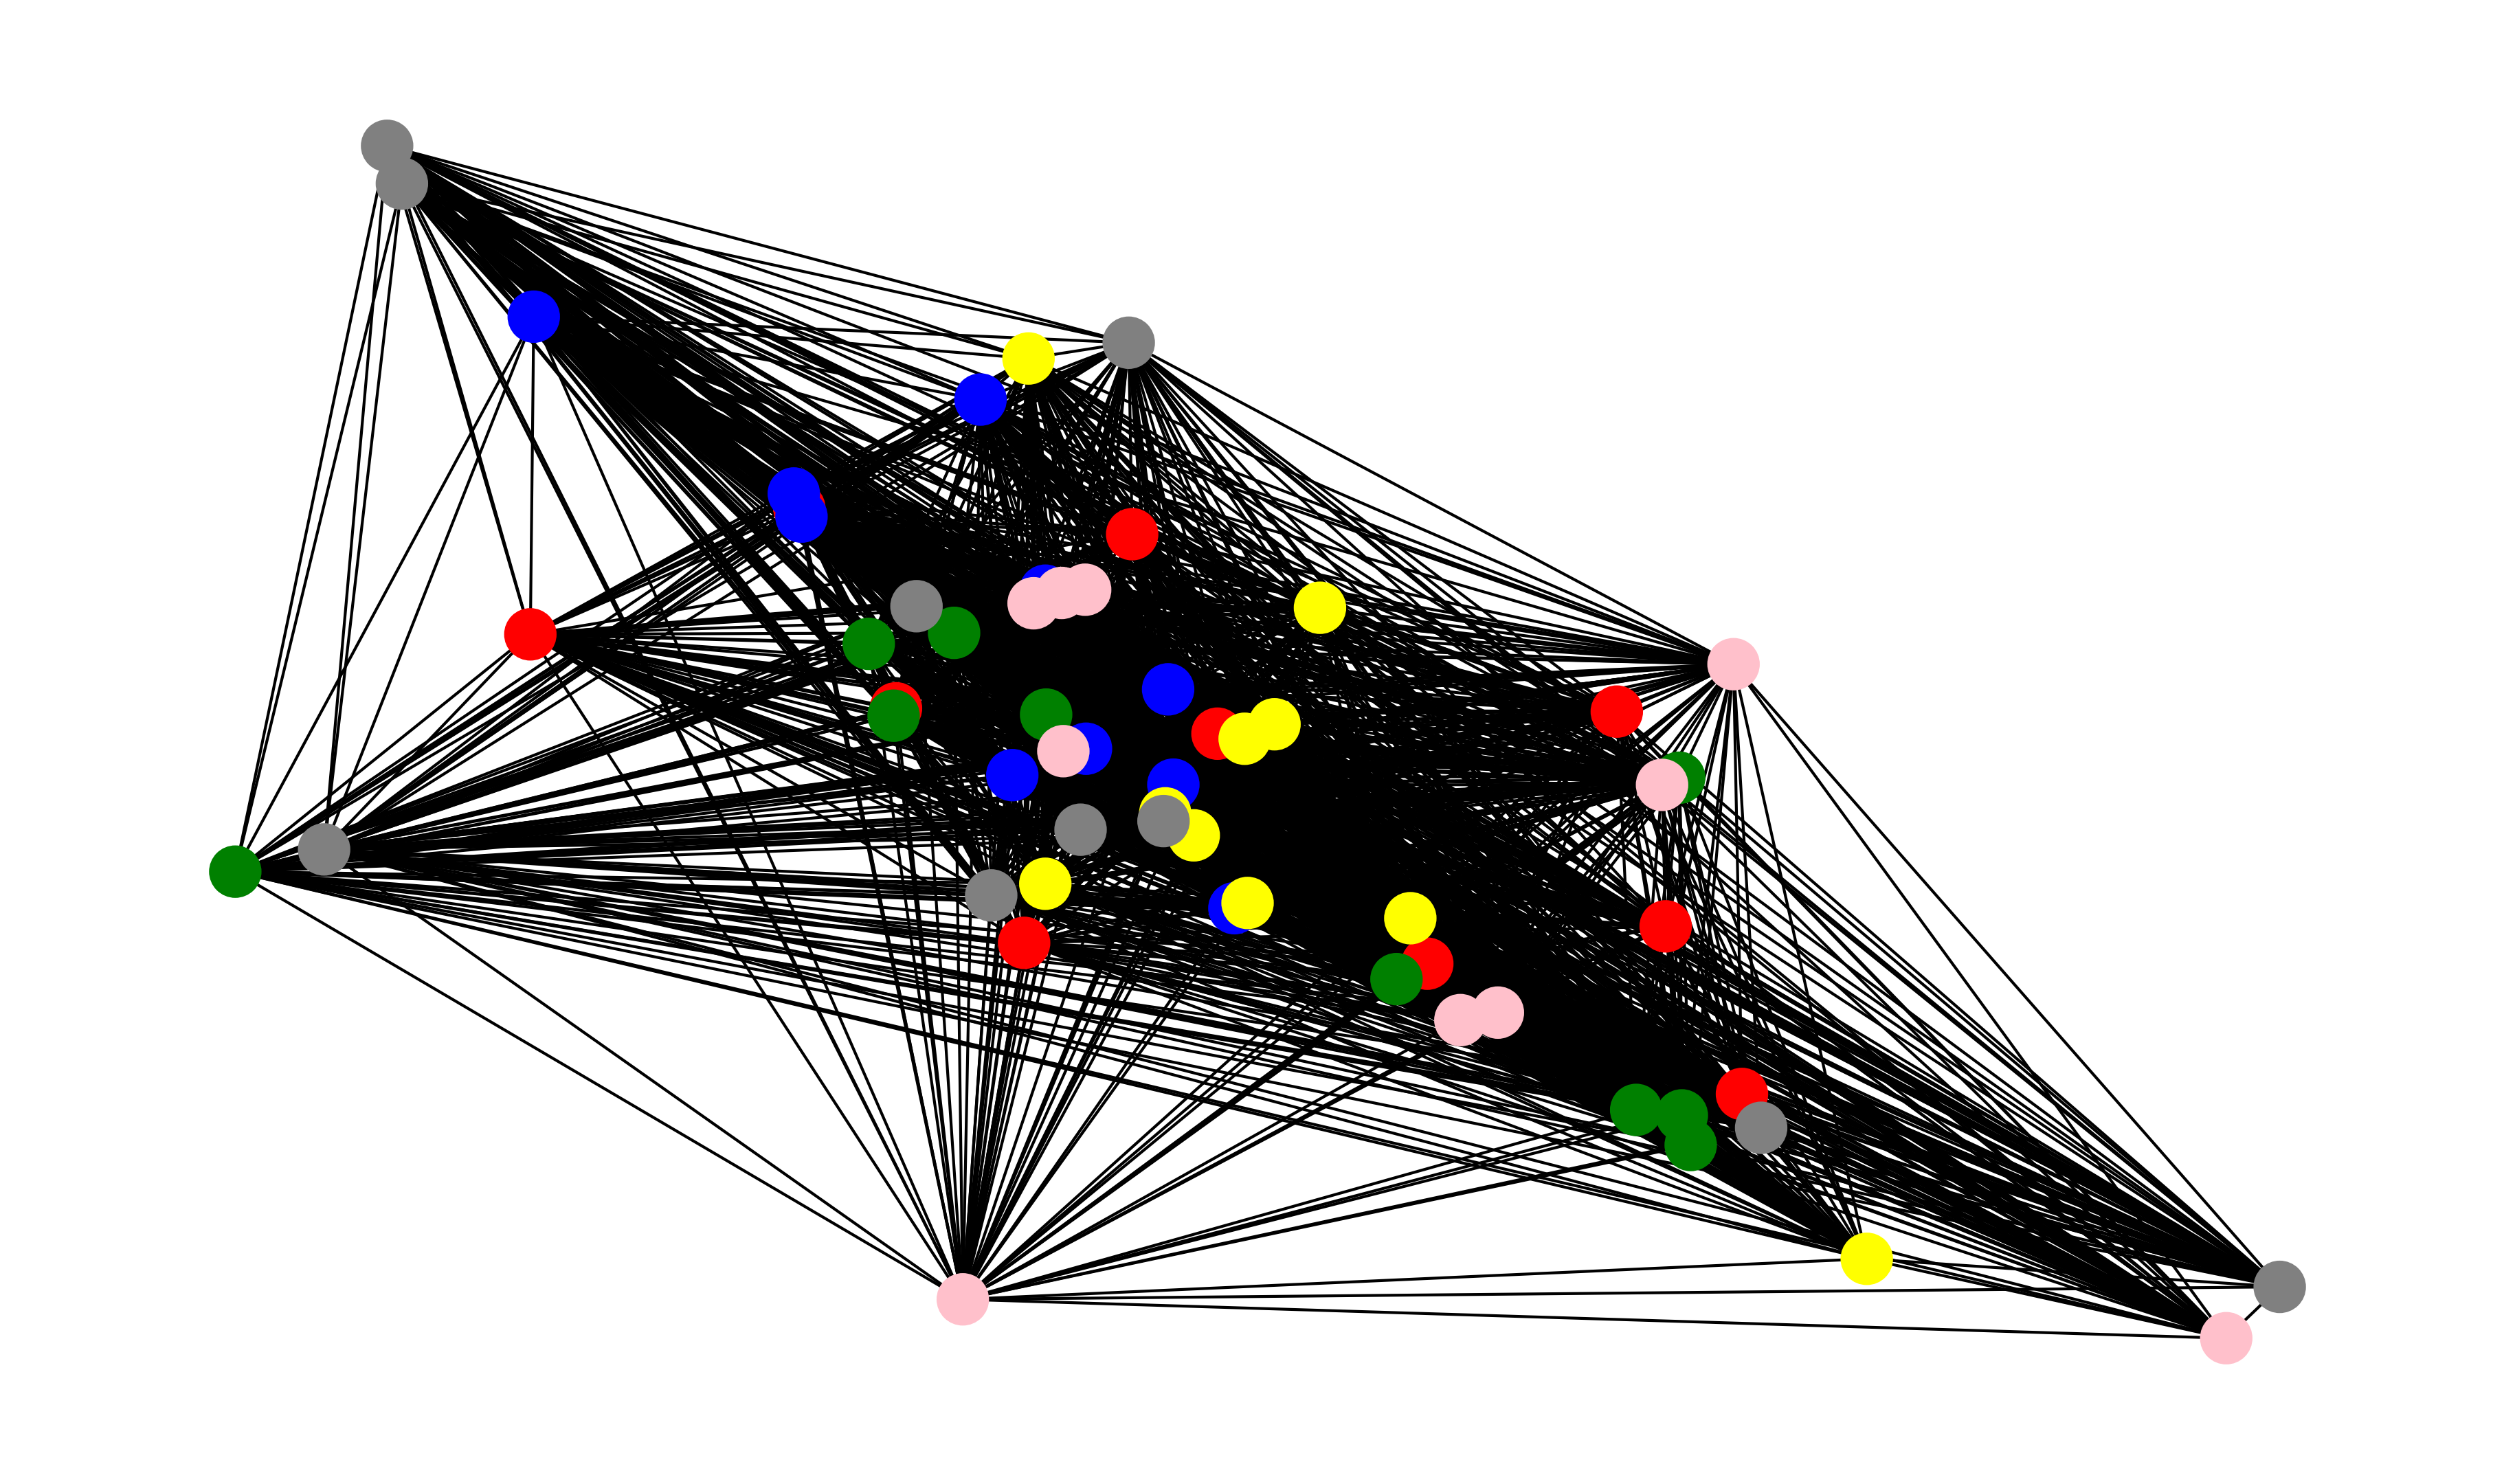

In [65]:
import itertools
labels = list(itertools.chain.from_iterable([[neuro]*nb_images_per_class for neuro in neurotransmitters]))
colormap = dict(zip(neurotransmitters, ['red', 'blue', 'green', 'pink', 'yellow', 'grey']))

colors = [colormap[label] for label in labels]


import networkx as nx
plt.figure(figsize=(12,7), dpi = 300)
G = nx.Graph()
for i in range(A_dim):
    for j in range(A_dim):
        G.add_edge(i, j, weight = np.exp(1000*A[i,j]))
G.remove_edges_from(nx.selfloop_edges(G))
nx.draw(G, node_color = colors, pos=nx.spring_layout(G))
plt.show()

100%|██████████| 499/499 [10:10<00:00,  1.22s/it]


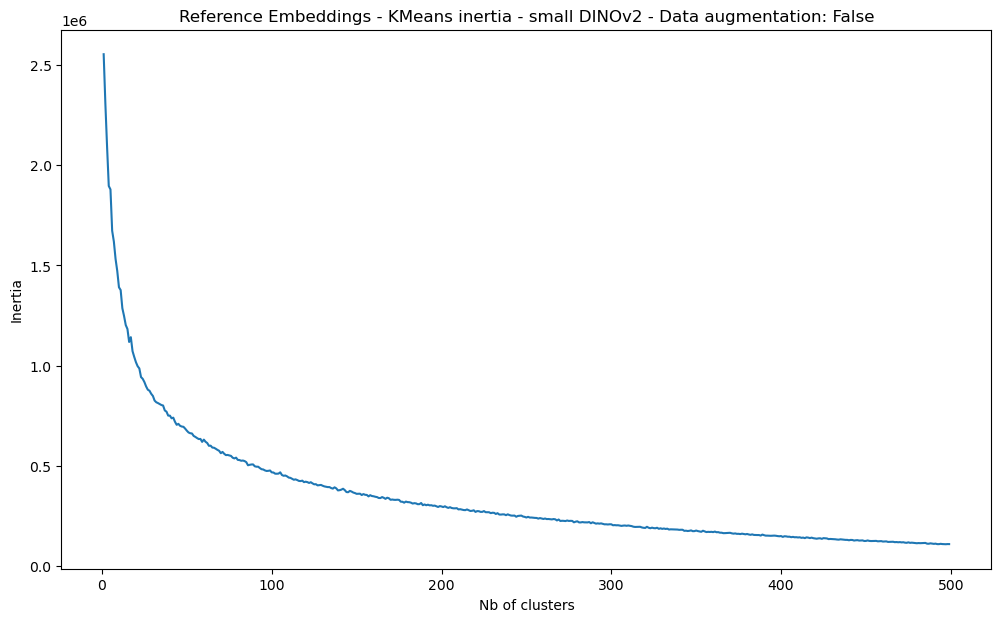

In [70]:
from sklearn.cluster import KMeans
inertia_list = []
n_tests = 500 
for k in tqdm(range(1,n_tests)):
    kmeans = KMeans(n_clusters=k).fit(embds[0][0])
    inertia_list.append(kmeans.inertia_)
plt.figure(figsize=(12,7),dpi=100)
plt.plot([i for i in range(1, n_tests)], inertia_list)
plt.title(f'Reference Embeddings - KMeans inertia - {model_size} DINOv2 - Data augmentation: {data_aug}')
plt.ylabel('Inertia')
plt.xlabel('Nb of clusters')
plt.show()